# Assignment 1: Text Classification Using Linear Models (50 Points for CSE 447 and 60 Points for CSE 517)

In this project, you will implement linear text classifiers for sentiment analysis. We will be working with [Stanford Sentiment Tree (SST) Bank](https://nlp.stanford.edu/sentiment/) which contains movie reviews with sentiment labels. We will consider both the binary version (only two labels positive and negative) as well as 5 label version (very negative, negative, neutral, positive, very positive). In particular you will learn:

- How to convert text inputs to features
- How to train logistic regression models from scratch
- How to use Autograd functionality from Pytorch to train models
- How to evaluate classification models
- Interpreting trained linear models

### Important notes about the autograder for this assignment:

*   To submit the coding part of this assignment to Gradescope, download your .ipynb notebook in .ipynb form and submit the following files, much must be named **exactly** as follows in order for the autograder to work:
    * CSE447_Assignment1.ipynb
    * test_data_with_binary_predictions.csv
    * test_data_with_multiclass_predictions.csv
    * adversarial_examples.csv *(extra credit for 447, only required for 517)*
*   At a low-load time on Gradescope, the autograder for this assignment takes about **eleven minutes** to run. We recommend submitting the code part of your assignment with enough time before the deadline to allow the autograder to run, and for you to investigate/correct any issues it flags.
*   You'll see that there are several places in the notebook with tags in comments like `# <NO_AUTOGRADE> ... # </NO_AUTOGRADE>`.
Any code between such tags will NOT be run by the autograder.
Note that our autograder does not use your trained models; it directly uses your function implementations to test functionality.
    * Please make sure that when you add code that might take a long time to run that you put it INSIDE these tags to avoid long autograder runtimes or crashing (e.g. training a model, hyperparameter search, adversarial example exploration). Also make sure that any code within the tags is self-contained -- **no other code should depend on any variables defined within the tags**.

*   In addition, make sure your notebook can run from top to bottom without errors. If it does not, the autograder will crash when processing your submission.

We will start by loading the datasets that we will be working with today.

In [1]:
# <NO_AUTOGRADE>

In [2]:
%%bash

# get any other necessary files for this project

if [ ! -e "data-needed.txt" ]; then
  if [ ! -e "data_path_to_download_url.py" ]; then
    wget https://raw.githubusercontent.com/serrano-s/NLPassignments-students/refs/heads/main/data_path_to_download_url.py
  else
    echo "data_path_to_download_url.py script already downloaded to runtime"
  fi

  wget https://raw.githubusercontent.com/serrano-s/NLPassignments-students/refs/heads/main/assignments/LogisticRegression/WithSentimentAnalysis/data-needed.txt

  # download all data files needed for the student-release version of this project (i.e., no hidden test files)
  DATA_NEEDED_FILE="data-needed.txt"
  closing_slash="/"
  while IFS= read -r line; do
    line="$(echo -e "${line}" | sed -e 's/^[[:space:]]*//' -e 's/[[:space:]]*$//')";
    dirs_to_check="${line%${closing_slash}*}"
    mkdir -p $dirs_to_check
    download_url=$(python data_path_to_download_url.py "$line")
    echo $download_url;
    wget "$download_url" -O "$line"
  done < "$DATA_NEEDED_FILE"
else
  echo "data-needed.txt (and presumably therefore all necessary data files) already downloaded to runtime"
fi

if [ ! -e "other-setup-needed.sh" ]; then
  wget https://raw.githubusercontent.com/serrano-s/NLPassignments-students/refs/heads/main/assignments/LogisticRegression/WithSentimentAnalysis/other-setup-needed.sh
  bash other-setup-needed.sh
  rm data_path_to_download_url.py
else
  echo "other-setup-needed.sh (and presumably therefore all other necessary files) already downloaded to runtime"
fi

In [3]:
# Install required libraries
!pip install numpy
!pip install pandas
!pip install nltk
!pip install torch
!pip install tqdm
!pip install matplotlib
!pip install seaborn

In [4]:
# </NO_AUTOGRADE>

In [5]:
# We start by importing libraries that we will be making use of in the assignment.

# Note that for this assignment, you are NOT allowed to import libraries like
# sklearn or torcheval that include implementations of some of the code you'll
# be asked to write; if you want to import anything else that's not already
# included below, please be sure to ask first.
from typing import List, Dict, Tuple
import string
import tqdm
from typing import List, Dict
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import os
import json

nltk.download("punkt")
nltk.download("stopwords")

In [6]:
parent_dir = os.path.dirname(os.path.abspath("__file__"))
data_dir = os.path.join(parent_dir, "data")

In [7]:
train_df = pd.read_csv(f"{data_dir}/sst/sst_train_binary.csv")
dev_df = pd.read_csv(f"{data_dir}/sst/sst_dev_binary.csv")

train_df_multiclass = pd.read_csv(f"{data_dir}/sst/sst_train_multiclass.csv")
dev_df_multiclass = pd.read_csv(f"{data_dir}/sst/sst_dev_multiclass.csv")

In [8]:
train_df.head()

In [9]:
train_df_multiclass.head()

## Part 1: Converting Text To Features

Typical ML models work on the data described using mathematical objects like vectors and matrices, which are often referred to as features. These features can be of different types depending upon the downstream application. For example, when building a classifier to predict whether to give credit to a customer, we might consider features like their age, income, employement status, etc. In the same way, to build a classifier for textual data, we need a way to describe each text example in terms of numeric features which can then be fed to the classification algorithm of our choice.

### Exercise 1.1 Linguistic Features (2 Points)

Pre-deep learning era it was common to represent text data using features defined using linguistic insights for solving different tasks. E.g. Jurafsky and Martin define the following 6 features for sentiment analysis:

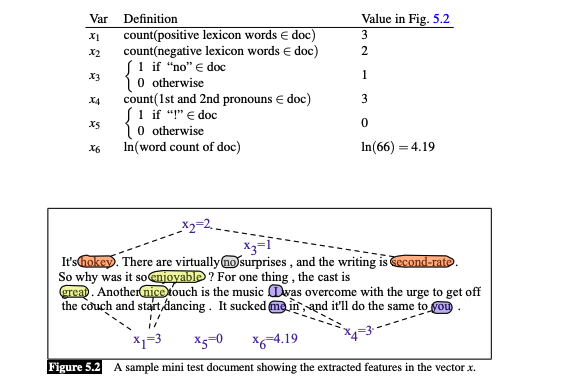

Implement the class `LinguisticVectorizer` which should extract these six features from the text documents. We have provided the positive lexicon and negative lexicon word lists in the constructor for you to use.

***Warning: While tokenizing the words out of the document, please use python native String.split() method rather than other fancy nlp packages (i.e. nltk.tokenize()).*** Otherwise the autotests may fail.

In [10]:
class LinguisticVectorizer:

    def __init__(self):

        with open(f"{data_dir}/lexicon/positive-words.txt", "r") as f:
            self.positive_words = []
            for line in f:
                if line.strip() != '' and not line.startswith(';'):
                    self.positive_words.append(line.strip())
        with open(f"{data_dir}/lexicon/negative-words.txt", "r") as f:
            self.negative_words = []
            for line in f:
                if line.strip() != '' and not line.startswith(';'):
                    self.negative_words.append(line.strip())

        self.first_person_pronouns = set(["i", "me", "my", "mine", "we", "us", "our", "ours"])
        self.second_person_pronouns = set(["you", "your", "yours"])

    def transform(self, documents: List[str]) -> torch.FloatTensor:

        """
        Extract the x_1, x_2, ..., x_6 features from Jurafsky and Martin for each text document.

        Inputs:
        - documents: a list of strings, where each string represents the text of a document.

        Returns:
        - features: a torch.FloatTensor of shape (N, 6) where N is the number of documents.

        Note: lexicon lists have all words in lowercase.
        """

        features = None


        raise NotImplementedError

        return features

In [11]:
# Sample test cases


def evaluate_test_case(
    input, output, expected_output, output_str="Output", atol=1e-4
) -> Dict:

    if input is not None:
        print("Input:\n", input)
    print(f"{output_str}:\n", output)
    print(f"Expected {output_str}:\n", expected_output)

    match = (
        output == expected_output
        if type(output) == str
        else np.allclose(output, expected_output, atol=atol)
    )

    if match:
        print("Test case passed! :)")

    else:
        print("Test case failed! :(")

    print("\n" + "=" * 50 + "\n")


def evaluate_list_test_cases(
    test_case_input, test_case_func_output, test_case_exp_output
):

    print(f"Input: {test_case_input}")
    print(f"Function Output: {test_case_func_output}")
    print(f"Expected Output: {test_case_exp_output}")

    if test_case_func_output == test_case_exp_output:
        print("Test Case Passed :)")
        print("**********************************\n")
        return True
    else:
        print("Test Case Failed :(")
        print("**********************************\n")
        return False


def evaluate_tensor_test_cases(
    test_case_input, test_case_func_output, test_case_exp_output
):

    print(f"Input: {test_case_input}")
    print(f"Function Output: {test_case_func_output}")
    print(f"Expected Output: {test_case_exp_output}")

    if torch.allclose(test_case_func_output, test_case_exp_output, atol=1e-4):
        print("Test Case Passed :)")
        print("**********************************\n")
        return True
    else:
        print("Test Case Failed :(")
        print("**********************************\n")
        return False


if __name__ == '__main__':
    print("Sample Test Case 1")
    linguistic_vectorizer = LinguisticVectorizer()
    documents = [
        "It's hokey . There are virtually no surprises , and the writing is second-rate . So why was it so enjoyable ? For one thing , the cast is great . Another nice touch is the music . I was overcome with the urge to get off the couch and start dancing . It sucked me in , and it'll do the same to you ."
    ]
    features = linguistic_vectorizer.transform(documents)
    expected_features = torch.FloatTensor([
        3, 2, 1, 3, 0, torch.log(torch.tensor(66.0))
    ])

    evaluate_tensor_test_cases(
        documents, features, expected_features
    )

    print("Sample Test Case 2")
    linguistic_vectorizer = LinguisticVectorizer()
    documents = [
        "I loved this movie . It was great . The music was awesome . I would watch it again .",
        "The movie was terrible . The acting was bad . I would not recommend it to anyone ."
    ]
    features = linguistic_vectorizer.transform(documents)
    expected_features = torch.FloatTensor([
        [3, 0, 0, 2, 0, torch.log(torch.tensor(20))],
        [1, 2, 0, 1, 0, torch.log(torch.tensor(18))]
    ])
    evaluate_tensor_test_cases(
        documents, features, expected_features
    )

Let's get the featurized representations for the pieces of text in our training and dev sets.

In [12]:
if __name__ == '__main__':
    linguistic_vectorizer = LinguisticVectorizer()
    train_features = linguistic_vectorizer.transform(train_df["sentence"])
    dev_features = linguistic_vectorizer.transform(dev_df["sentence"])

### Exercise 1.2 Bag of Words Features (6 Points)

While the linguistic features that we defined above might be effective for some cases, it is also very easy to find cases where they will miss modeling some important aspect of the original text. E.g., suppose we're working with more informally written text on social media, where words that are associated with positive sentiment (like "goat" or "queen") might not be captured in a dictionary of positive-sentiment words derived from a formal English dictionary, like the one we just used in counting positive-valence words. While we can define additional features to handle such cases, it can get very tedious trying to capture all such situations.

Bag of Words features are another method to encode documents into features and requires little manual interventions to define features. In bag of words, we represent a document as an unordered collection of words in that document. One way this is commonly done is by counting occurrence (or frequency) of each word in a given document and using it as a feature for training the classifier. The order in which these words occur in the text is not relevant and we are just concerned with which words are present in the text. Consider the following example to understand how bag of words are used to represent text.

As an example consider we have 2 examples present in our dataset:

x1: john likes to watch movies mary likes movies too

x2: mary also likes to watch football games

Based on these two documents we can get the list of all words that occur in this dataset which will be:

| index | word     |
|-------|----------|
| 0     | also     |
| 1     | football |
| 2     | games    |
| 3     | john     |
| 4     | likes    |
| 5     | mary     |
| 6     | movies   |
| 7     | to       |
| 8     | too      |
| 9     | watch    |

We can then define features for the two x1 and x2 as follows:


|    | also | football | games | john | likes | mary | movies | to | too | watch |
|----|------|----------|-------|------|-------|------|--------|----|-----|-------|
| x1 | 0    | 0        | 0     | 1    | 2     | 1    | 2      | 1  | 2   | 1     |
| x2 | 1    | 1        | 1     | 0    | 1     | 1    | 0      | 0  | 0   | 0     |

These features can then be used to train an ML model. To summarize, the following two steps must be followed to create bag of word representations of the text examples in a dataset.

- Step 1: Create a word vocabulary by iterating through all the documents in the **training** dataset, storing all the unique words that are present in each document. Also maintain mappings to map each word to an index and vice-versa, which we will need to define values for each feature dimension.

- Step 2: For each document in the training and test sets, get the frequency of each word in our vocabulary and use it to define feature for that example.


Below you will implement the class `BOWVectorizer`, which should provide the functionality to convert text documents into BoW features by executing the two steps we described above. Specifically, you will be implementing the `fit` function that creates vocabulary and word-to-index mappings from training data and a `transform` function which converts a text into predetermined BoW features.

In [13]:
class BOWVectorizer:

    def fit(self, train_data: List[str]):

        """
        Given a list of documents in training data creates a word vocabulary and containing all words that occur in the training data.

        Inputs:
        - train_data: List of strings where each string represents a document

        Note: Make sure to sort the words in your vocabulary in lexicographical order.
        """

        self.vocab = None
        self.word2idx = None

        raise NotImplementedError

    def transform(self, documents: List[str]) -> torch.FloatTensor:

        """
        Converts a list of documents into a matrix of token counts.

        Inputs:
        - documents: List of strings where each string represents a document

        Outputs:
        - Returns a torch.tensor of shape (N, V) where N is the number of documents and V is the size of the vocabulary
        """

        bow_features = None


        raise NotImplementedError

        return bow_features

Sample test cases:

In [14]:
if __name__ == '__main__':
    print("Running Sample Test cases for `fit` method")
    print("Sample Test Case 1:")
    documents = [
        "john likes to watch movies mary likes movies too",
        "mary also likes to watch football games",
    ]
    bow_vectorizer = BOWVectorizer()
    bow_vectorizer.fit(documents)
    test_documents = [
        "john likes to watch movies mary likes movies too",
        "mary also likes to watch football games",
    ]
    expected_answer = torch.tensor([[0, 0, 0, 1, 2, 1, 2, 1, 1, 1], [1, 1, 1, 0, 1, 1, 0, 1, 0, 1]]).float()
    evaluate_tensor_test_cases(
        test_documents, bow_vectorizer.transform(test_documents), expected_answer
    )

    ## BEGIN HIDDEN TESTS

    documents = [
        "john likes to watch movies mary likes movies too",
        "mary also likes to watch football games",
    ]
    bow_vectorizer = BOWVectorizer()
    bow_vectorizer.fit(documents)

    test_documents = [
        "not all those who wander are lost",
        "mary also likes to watch football games but john hates football and mary",
    ]
    expected_answer = torch.tensor(
        [
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [1, 2, 1, 1, 1, 2, 0, 1, 0, 1],
        ]
    ).float()
    evaluate_tensor_test_cases(
        test_documents, bow_vectorizer.transform(test_documents), expected_answer
    )

    documents = [
        "not all those who wander are lost",
        "Deeds will not be less valiant because they are unpraised",
        "Let him not vow to walk in the dark , who has not seen the nightfall",
    ]
    bow_vectorizer = BOWVectorizer()
    bow_vectorizer.fit(documents)
    test_documents = ["not all those who wander are lost"]
    expected_answer = torch.tensor(
        [[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0]]
    ).float()
    evaluate_tensor_test_cases(
        test_documents, bow_vectorizer.transform(test_documents), expected_answer
    )
    ## END HIDDEN TESTS

Let's create BoW Features for the SST Dataset.

In [15]:
if __name__ == '__main__':
    # Training the BOWVectorizer on the SST training data
    bow_vectorizer  = BOWVectorizer()
    bow_vectorizer.fit(train_df["sentence"].values)

    # Selecting the first training example
    train_example = train_df["sentence"].values[0]
    features = bow_vectorizer.transform([train_example])
    print(f"Shape of the feature vector : {features.shape}")
    print(f"Number of training examples : {len(train_df)}")

As you can see, we have around 18k features for each example! This is especially concerning because our training dataset size is less than half of the number of features. This can very easily lead the model to overfit on training data. Recall that each feature corresponds to a word in the vocabulary. One way we can reduce the features is by normalizing words in the vocabulary. E.g. currently we have been treating lowercase and uppercase versions of a word as different words. We can apply *case folding* i.e. lowercasing all the words in our dataset. Another trick that can significantly reduce the number of features is to get rid of words which occur very rarely in the training data and replace them with an \<unk\> token (short for "unknown token"). Similarly, we can remove punctuation from the text. We can also get rid of the so called *stop-words*. These are the words which are very commonly used in a language but often do not carry significant meaning, e.g. "the", "he", "for" etc. The NLTK package provides us a list of stop words which can be accessed using the following code:

```
from nltk.corpus import stopwords
STOPWORDS = stopwords.words("english")
```

Implement `BOWVectorizerWNomalizer` class below, which first applies the three text processing techniques mentioned above, to the documents both before we use them to train the features or before transforming them.


**Warning: Please implement the four processing techniques in the following order, and compute the word count with normalized words except \<unk\>. Change the ordering or count unnormalized words may result in autotest failure:**

1. Lowercase
2. Remove punctuation
3. Remove stop words
4. Convert low frequency words to \<unk\>

In [16]:
from collections import Counter

class BOWVectorizerWNormalizer(BOWVectorizer):

    def __init__(self, lower_case=True, replace_rare_words_wth_unks = True, remove_punctuation=True, remove_stopwords=True, min_word_freq=3):

        self.lower_case = lower_case
        self.replace_rare_words_wth_unks = replace_rare_words_wth_unks
        self.remove_punctuation = remove_punctuation
        self.remove_stopwords = remove_stopwords
        self.min_word_freq = min_word_freq

        self.stop_words = set(nltk.corpus.stopwords.words("english"))
        self.punctuation = set(string.punctuation)

    def fit(
        self,
        train_data: List[str]
    ):
        """
        Given a list of documents in training data creates a word vocabulary containing all words **post normalization** that occur in the training data.

        Inputs:
        - train_data: List of strings where each string represents a document

        """

        self.vocab = None
        self.word2idx = None


        raise NotImplementedError

    def transform(self, documents: List[str]) -> torch.FloatTensor:
        """
        Transforms a list of documents into a matrix of token counts.

        Inputs:
        - documents: List of strings where each string represents a document

        Outputs:
        - Returns a torch.tensor of shape (N, V) where N is the number of documents and V is the size of the vocabulary
        """

        bow_features = None


        raise NotImplementedError

        return bow_features

    # Helper functions to normalize the document

    # YOUR CODE HERE


In [17]:
# <NO_AUTOGRADE>

In [18]:
if __name__ == '__main__':
    bow_vectorizer = BOWVectorizerWNormalizer(
        lower_case=True,
        replace_rare_words_wth_unks=True,
        remove_punctuation=True,
        remove_stopwords=True,
    )

    bow_vectorizer.fit(train_df["sentence"].values)

    ref_train_features = bow_vectorizer.transform(train_df["sentence"].values)
    ref_train_features.nonzero().shape

    train_df["sentence"].values[0]

    print(bow_vectorizer.transform(train_df["sentence"].values).shape)

In [19]:
# </NO_AUTOGRADE>

In [20]:
if __name__ == '__main__':
    print("Running Test Cases for BOWVectorizerWNormalizer")

    # Test Case 1: Testing lowercase and punctuation handling
    print("\nTest Case 1: Testing case sensitivity and punctuation")
    documents = [
        "The CAT! is sitting.",
        "Cats ARE running!",
    ]
    bow_vectorizer = BOWVectorizerWNormalizer(
        lower_case=True,
        remove_punctuation=True,
        remove_stopwords=False,
        replace_rare_words_wth_unks=False
    )
    bow_vectorizer.fit(documents)
    test_documents = [
        "The CAT! is sitting.",
        "Cats ARE running!",
    ]
    # Expected vocabulary: ['are', 'cat', 'cats', 'is', 'running', 'sitting', 'the']
    expected_answer = torch.tensor([
        [0, 1, 0, 1, 0, 1, 1],
        [1, 0, 1, 0, 1, 0, 0]
    ]).float()
    evaluate_tensor_test_cases(
        test_documents, bow_vectorizer.transform(test_documents), expected_answer
    )

    # Test Case 2: Testing stopword removal
    print("\nTest Case 2: Testing stopword removal")
    documents = [
        "the cat is on the mat",
        "a dog is in the yard"
    ]
    bow_vectorizer = BOWVectorizerWNormalizer(
        lower_case=True,
        remove_punctuation=True,
        remove_stopwords=True,
        replace_rare_words_wth_unks=False
    )
    bow_vectorizer.fit(documents)
    test_documents = [
        "the cat is on the mat",
        "a dog is in the yard"
    ]
    # Expected vocabulary: ['cat', 'dog', 'mat', 'yard']
    expected_answer = torch.tensor([
        [1, 0, 1, 0],
        [0, 1, 0, 1]
    ]).float()
    evaluate_tensor_test_cases(
        test_documents, bow_vectorizer.transform(test_documents), expected_answer
    )

    # Test Case 3: Testing rare word replacement
    print("\nTest Case 3: Testing rare word replacement")
    documents = [
        "rare word appears once",
        "common word appears frequently",
        "common word appears again",
        "common word appears more"
    ]
    bow_vectorizer = BOWVectorizerWNormalizer(
        lower_case=True,
        remove_punctuation=True,
        remove_stopwords=False,
        replace_rare_words_wth_unks=True,
        min_word_freq=3
    )
    bow_vectorizer.fit(documents)
    test_documents = [
        "rare word appears once",
        "common word appears frequently"
    ]
    # Expected vocabulary: ['<unk>', 'appears', 'common', 'word']
    expected_answer = torch.tensor([
        [2, 1, 0, 1],
        [1, 1, 1, 1]
    ]).float()
    evaluate_tensor_test_cases(
        test_documents, bow_vectorizer.transform(test_documents), expected_answer
    )

    # Test Case 4: Testing all features together
    print("\nTest Case 4: Testing all normalizations together")
    documents = [
      "The QUICK! brown fox.",
      "Quick BROWN foxes!",
      "THE quick Fox jumps.",
      "The FOX jumped quickly!"
    ]
    bow_vectorizer = BOWVectorizerWNormalizer(
      lower_case=True,
      remove_punctuation=True,
      remove_stopwords=True,
      replace_rare_words_wth_unks=True,
      min_word_freq=2
    )
    bow_vectorizer.fit(documents)
    test_documents = [
      "The QUICK! brown fox.",
      "The FOX jumped quickly!"
    ]
    # Expected vocabulary: ['<unk>', 'brown', 'fox', 'quick',]
    expected_answer = torch.tensor([
      [0, 1, 1, 1],
      [2, 0, 1, 0]
    ]).float()
    evaluate_tensor_test_cases(
      test_documents, bow_vectorizer.transform(test_documents), expected_answer
    )

In [21]:
if __name__ == '__main__':
    print("Normalization by applying only lower casing")
    bow_vectorizer = BOWVectorizerWNormalizer(
        lower_case=True, replace_rare_words_wth_unks = False, remove_punctuation=False, remove_stopwords=False
    )
    bow_vectorizer.fit(train_df["sentence"].values)
    train_example = train_df["sentence"].values[0]
    features = bow_vectorizer.transform([train_example])
    print(f"Shape of the feature vector : {features.shape}")

    print("Normalization by also replacing rare words with <unk>")
    bow_vectorizer = BOWVectorizerWNormalizer(
        lower_case=True, replace_rare_words_wth_unks = True,  remove_punctuation=False, remove_stopwords=False
    )
    bow_vectorizer.fit(train_df["sentence"].values)
    train_example = train_df["sentence"].values[0]
    features = bow_vectorizer.transform([train_example])
    print(f"Shape of the feature vector : {features.shape}")

    print("Normalization by also removing punctuation")
    bow_vectorizer = BOWVectorizerWNormalizer(
        lower_case=True,
        replace_rare_words_wth_unks=True,
        remove_punctuation=True,
        remove_stopwords=False,
    )
    bow_vectorizer.fit(train_df["sentence"].values)
    train_example = train_df["sentence"].values[0]
    features = bow_vectorizer.transform([train_example])
    print(f"Shape of the feature vector : {features.shape}")

    print("Normalization by also removing stopwords")
    bow_vectorizer = BOWVectorizerWNormalizer(
        lower_case=True,
        replace_rare_words_wth_unks=True,
        remove_punctuation=True,
        remove_stopwords=True,
    )
    bow_vectorizer.fit(train_df["sentence"].values)
    features = bow_vectorizer.transform([train_example])
    print(f"Shape of the feature vector : {features.shape}")

You should see 16473 features with just lowercasing, 5535 with lowercasing and replacing rare words with \<unk\>, 5521 features on also removing punctuation, and 5392 features on applying all the four normalization techniques. (Regarding removing punctuation: while this can be done in a few different ways, for this assignment, our test cases assume that you've done so by removing any occurrences of punctuation from a token while leaving the rest of it intact. For example, the token three-year-old would become threeyearold if you're normalizing in a way that matches our implementation.)

As you can see we were able to reduce roughly 4 times the original number of features, and we have now way fewer features than the number of training examples. We can apply even more aggressive techniques like lemmatization and stemming to go even further, but these techniques can be tricky to work with  (see Chapter 2, section 2.6 of Jurafsky and Martin for details) and often not lead to much improved performance.

Let's get our new set of features for our training and dev sets now.

In [22]:
if __name__ == '__main__':
    bow_vectorizer = BOWVectorizerWNormalizer(
        lower_case=True, replace_rare_words_wth_unks=True,  remove_punctuation=True, remove_stopwords=True
    )
    bow_vectorizer.fit(train_df["sentence"].values)
    train_bow_features = bow_vectorizer.transform(train_df["sentence"].values)
    dev_bow_features = bow_vectorizer.transform(dev_df["sentence"].values)

    print(f"Shape of the training feature matrix : {train_bow_features.shape}")
    print(f"Shape of the dev feature matrix : {dev_bow_features.shape}")

## Part 2: Binary Logistic Regression

We will now start building our first text classifier! We will start with Logistic Regression for binary classification i.e. where each input can be classified into one of the two labels. Consider an input $\pmb{x} \in \mathbb{R}^d$ defining the feature vector and label $y \in \{0,1\}$. Recall from the lectures that logistic regression has the following functional form:

$$ \hat{y} = P(y = 1) = \sigma(\pmb{w}^T\pmb{x} + b)$$

where, $\sigma$ is the sigmoid function:

$$\sigma(x) = \frac{1}{1 + \exp(-x)}$$

and the weight vector $\pmb{w} \in \mathbb{R}^d$ and the bias term $b \in \mathbb{R}$ are the learnable parameters in the model.

In [23]:
if __name__ == '__main__':
    # Getting labels for the training and dev data binary classification
    y_train = torch.tensor(train_df["label"].values).unsqueeze(1)
    y_dev = torch.tensor(dev_df["label"].values).unsqueeze(1)
    print(f"Shape of the training labels : {y_train.shape}")
    print(f"Shape of the dev labels : {y_dev.shape}")

In [24]:
# Check label distribution

if __name__ == '__main__':
    fig = plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(train_df["label"], stat="probability")
    plt.title("Training Data Label Distribution")

    plt.subplot(1, 2, 2)
    sns.histplot(dev_df["label"], stat="probability")
    plt.title("Dev Data Label Distribution")

### Exercise 2.1: Logistic Regression Prediction (2 Points)
We shall soon see how we can learn the parameters $\pmb{w}$ and $b$ from training data. For now implement `LogisticRegression` the class below, which initializes the parameters (to zeros) and provides a method to get the output from a logistic regression model.

In [25]:
class LogisticRegression:

    def __init__(self, d: int) -> None:
        """
        Initialize the weights and bias to zeros for the logistic regression model.

        Inputs:
        - d: An integer representing the number of features
        """

        self.weights = None
        self.bias = None


        raise NotImplementedError


    def sigmoid(self, z: torch.FloatTensor) -> torch.FloatTensor:
        """
        Compute the sigmoid of z

        Inputs:
        - z : A torch.FloatTensor of shape (N, 1) or (N,) where N is the number of samples

        Returns:
        - A torch.FloatTensor of shape (N, 1) or (N,) where N is the number of samples
        """


        raise NotImplementedError

    def forward(self, x: torch.FloatTensor) -> torch.FloatTensor:
        """
        Compute the forward pass of the logistic regression model.

        Inputs:
        - x : A torch.FloatTensor of shape (N, d) where N is the number of samples and d number of features

        Returns:
        - A torch.FloatTensor of shape (N, 1) where N is the number of samples
        """


        raise NotImplementedError

    def __call__(self, x: torch.FloatTensor) -> torch.FloatTensor:
        """
        Make a forward pass call to the logistic regression model.
        Only exists so that we can directly call the object to make predictions instead of calling the forward method.

        Inputs:
        - x : A torch.FloatTensor of shape (N, d) where N is the number of samples and d number of features

        Returns:
        - A torch.FloatTensor of shape (N, 1) where N is the number of samples
        """

        return self.forward(x)


In [26]:
if __name__ == '__main__':
    # Sample Test Cases
    print("Running Sample Test Case 1")
    d = 6
    logistic_regression = LogisticRegression(d)
    print("Initialized weights: {}".format(logistic_regression.weights))
    print("Initialized bias: {}".format(logistic_regression.bias))
    x = torch.tensor([[1, 2, 3, 4, 5, 6]], dtype=torch.float)
    output = logistic_regression(x)
    expected_output = torch.tensor([[0.5]])
    evaluate_tensor_test_cases(x, output, expected_output)

    print("Running Sample Test Case 2")
    d = 4
    logistic_regression = LogisticRegression(d)
    torch.manual_seed(42)
    # Modifying weights and bias
    logistic_regression.weights = torch.randn(d, 1)
    logistic_regression.bias = torch.randn(1)
    print("Modified weights: {}".format(logistic_regression.weights))
    print("Modified bias: {}".format(logistic_regression.bias))
    x = torch.tensor([[1, 2, 3, 4]], dtype=torch.float)
    output = logistic_regression(x)
    expected_output = torch.tensor([[0.7495]])
    evaluate_tensor_test_cases(x, output, expected_output)

    print("Running Sample Test Case 3")
    d = len(train_bow_features[0])
    logistic_regression = LogisticRegression(d)
    torch.manual_seed(42)
    # Modifying weights and bias
    logistic_regression.weights = torch.randn(d, 1)
    logistic_regression.bias = torch.randn(1)
    print("Modified weights: {}".format(logistic_regression.weights))
    print("Modified bias: {}".format(logistic_regression.bias))
    output = logistic_regression(train_bow_features[:10])
    expected_output = torch.tensor(
        [
            [0.1411],
            [1.0000],
            [0.9991],
            [0.9517],
            [0.6809],
            [0.9971],
            [0.6737],
            [0.1971],
            [0.3675],
            [0.2738]
        ]
    )
    evaluate_tensor_test_cases(train_bow_features[:10], output, expected_output)

### Exercise 2.2 Binary Cross Entropy Loss (1 Point)

To train our model we need to first define a loss function that measures the error between the model's prediction of the label ($\hat{y}$) and the ground truth label ($y$). For logistic regression with binary labels, we use binary cross entropy (BCE) loss. For a given prediction, ground truth pair, the BCE loss is given as:

$$L_{\text{BCE}}(\hat{y}, y) = -[y \log \hat{y} + (1 - y) \log (1 - \hat{y})]$$

Plugging in the value of $\hat{y}$, we get:

$$ L_{\text{BCE}}(\pmb{w}, b \mid \pmb{x}, y) = -[y \log \sigma(\pmb{w}^T\pmb{x} + b) + (1 - y) \log (1 - \sigma(\pmb{w}^T\pmb{x} + b))]$$

To compute loss over the entire dataset $D$, we simply average the loss for all examples:

$$ L_{\text{BCE}}(\pmb{w}, b \mid D) = \frac{1}{m} \sum_{i = 1}^{m} L_{\text{BCE}}(\hat{y}_i, y_i)$$

where $m$ is the number of examples in the dataset.

Implement the `bce_loss` function below, which takes in the predicted and ground truth labels and computes the average BCE loss.

In [27]:
def bce_loss(
    y_pred : torch.FloatTensor,
    y_true : torch.FloatTensor
) -> float:
    """
    Compute the binary cross entropy loss between y_pred and y_true.

    Inputs:
    - y_pred : A torch.FloatTensor of shape (N, 1) or (N,) where N is the number of samples
    - y_true : A torch.FloatTensor of shape (N, 1) or (N,) where N is the number of samples

    Returns:
    - A float representing the binary cross entropy loss
    """


    raise NotImplementedError


In [28]:
# Sample Test Cases

if __name__ == '__main__':
    print("Running Sample Test Case 1")
    y_pred = torch.tensor([0.1])
    y_true = torch.tensor([1.0])
    output = bce_loss(y_pred, y_true)
    expected_output = 2.3025851249694824
    print(f"y_pred: {y_pred}")
    print(f"y_true: {y_true}")
    print(f"Output: {output}")
    print(f"Expected Output: {expected_output}")
    if output == expected_output:
        print("Test Case Passed :)")
    else:
        print("Test Case Failed :(")
    print("**********************************\n")

    print("Running Sample Test Case 2")
    y_pred = torch.tensor([[0.5]])
    y_true = torch.tensor([[1.0]])
    output = bce_loss(y_pred, y_true)
    expected_output = 0.6931471824645996
    print(f"y_pred: {y_pred}")
    print(f"y_true: {y_true}")
    print(f"Output: {output}")
    print(f"Expected Output: {expected_output}")
    if torch.allclose(torch.tensor(output), torch.tensor(expected_output), atol=1e-4):
        print("Test Case Passed :)")
    else:
        print("Test Case Failed :(")
    print("**********************************\n")


    print("Running Sample Test Case 3")
    y_pred = torch.tensor([0.9])
    y_true = torch.tensor([1.0])
    output = bce_loss(y_pred, y_true)
    expected_output = 0.10536054521799088
    print(f"y_pred: {y_pred}")
    print(f"y_true: {y_true}")
    print(f"Output: {output}")
    print(f"Expected Output: {expected_output}")
    if torch.allclose(torch.tensor(output), torch.tensor(expected_output), atol=1e-4):
        print("Test Case Passed :)")

    else:
        print("Test Case Failed :(")
    print("**********************************\n")

    print("Running Sample Test Case 4")
    y_pred = torch.tensor([0.99])
    y_true = torch.tensor([1.0])
    output = bce_loss(y_pred, y_true)
    expected_output = 0.010050326585769653
    print(f"y_pred: {y_pred}")
    print(f"y_true: {y_true}")
    print(f"Output: {output}")
    print(f"Expected Output: {expected_output}")
    if torch.allclose(torch.tensor(output), torch.tensor(expected_output), atol=1e-4):
        print("Test Case Passed :)")

    else:
        print("Test Case Failed :(")
    print("**********************************\n")


    print("Running Sample Test Case 5")
    y_pred = torch.tensor([0])
    y_true = torch.tensor([1])
    output = bce_loss(y_pred, y_true)
    expected_output = torch.inf
    print(f"y_pred: {y_pred}")
    print(f"y_true: {y_true}")
    print(f"Output: {output}")
    print(f"Expected Output: {expected_output}")
    if torch.eq(torch.tensor(output), torch.tensor(expected_output)):
        print("Test Case Passed :)")
    else:
        print("Test Case Failed :(")
    print("**********************************\n")

    print("Running Sample Test Case 6")
    y_pred = torch.tensor([1])
    y_true = torch.tensor([1])
    output = bce_loss(y_pred, y_true)
    expected_output = torch.nan
    print(f"y_pred: {y_pred}")
    print(f"y_true: {y_true}")
    print(f"Output: {output}")
    print(f"Expected Output: {expected_output}")
    if torch.isnan(torch.tensor(output)):
        print("Test Case Passed :)")
    else:
        print("Test Case Failed :(")
    print("**********************************\n")

    print("Running Sample Test Case 7")
    y_pred = torch.tensor([[0.1, 0.3, 0.5, 0.7, 0.9, 0.99]])
    y_true = torch.tensor([[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]])
    output = bce_loss(y_pred, y_true)
    expected_output = (
        torch.tensor(
            [
                2.3025851249694824,
                1.2039728164672852,
                0.6931471824645996,
                0.3566749691963196,
                0.10536054521799088,
                0.010050326585769653,
            ]
        )
        .mean()
        .item()
    )
    print(f"y_pred: {y_pred}")
    print(f"y_true: {y_true}")
    print(f"Output: {output}")
    print(f"Expected Output: {expected_output}")
    if torch.allclose(torch.tensor(output), torch.tensor(expected_output), atol=1e-4):
        print("Test Case Passed :)")
    else:
        print("Test Case Failed :(")
    print("**********************************\n")


    print("Running Sample Test Case 8")
    y_pred = torch.tensor([[0.1, 0.3, 0.5, 0.7, 0.9, 0.99]])
    y_true = torch.tensor([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]])
    output = bce_loss(y_pred, y_true)
    expected_output = (
        torch.tensor(
            [
                0.10536054521799088,
                0.3566749691963196,
                0.6931471824645996,
                1.2039728164672852,
                2.3025848865509033,
                4.605171203613281,
            ]
        )
        .mean()
        .item()
    )
    print(f"y_pred: {y_pred}")
    print(f"y_true: {y_true}")
    print(f"Output: {output}")
    print(f"Expected Output: {expected_output}")
    if torch.allclose(torch.tensor(output), torch.tensor(expected_output), atol=1e-4):
        print("Test Case Passed :)")
    else:
        print("Test Case Failed :(")
    print("**********************************\n")

### Exercise 2.3: Gradient Descent for Logistic Regression (4 Points)

We can now start training our sentiment classifier. One of the most commonly used optimization algorithms used in machine (and deep) learning is gradient descent. Recall from lectures that in gradient descent we iteratively update the weights of the model in the opposite direction of the gradient of loss function w.r.t. to the weights, i.e.,

$$ \theta^{t + 1} = \theta^t - \frac{\eta}{m} \nabla_{\theta} \sum_{i=1}^{m} L(f(x_i; \theta), y_i) $$

Note that for logistic regression, $L(f(x; \theta), y ) = L_{\text{BCE}}(\hat{y}, y)$.

$\theta$ here denotes the parameters of the model, which for us are simply the weights $\pmb{w}$ and bias $b$. $\eta$ is also called learning rate, which determines the strength of every the update (too low then the convergence will be slow and too high we might overshoot the local minima).

The gradient of the BCE loss w.r.t $\pmb{w}$ is given by:


$$ \nabla_{w} L_{\text{BCE}}(\hat{y}_i, y_i) = [ \frac{\partial L_{\text{BCE}}(\hat{y}_i, y_i)}{\partial w_1}, \cdots,  \frac{\partial L_{\text{BCE}}(\hat{y}_i, y_i)}{\partial w_d}]^T $$

$$ \frac{\partial L_{\text{BCE}}(\hat{y}_i, y_i)}{\partial w_j} = - (y_i - \hat{y}_i)x_{ij} $$

Note that $x_{ij}$ refers to the $j^{th}$ feature of $i^{th}$ input.
Similarly, for the bias term we get:

$$ \nabla_{b} L_{\text{BCE}}(\hat{y}_i, y_i) = \frac{\partial L_{\text{BCE}}(\hat{y}_i, y_i)}{\partial b} = - (y_i - \hat{y}_i) $$

Plugging these into our gradient descent equation we get:

$$ w^{t+1}_j = w^{t}_j - \frac{\eta}{m} \sum_{i=1}^m (\hat{y}_i - y_i)x_{ij}$$

$$b^{t+1} = b^{t} - \frac{\eta}{m} \sum_{i=1}^m (\hat{y}_i - y_i)$$

Before we begin our implementation, there are two points to note. First, you may have noticed that we sum over $m$ examples in our update equation. These are the all the examples in our training data. In practice, it can get very expensive to compute gradients w.r.t all examples, specially when we are dealing with huge datasets (millions or even billions of examples) and deep neural networks. In such cases, it is common to use stochastic or mini batch gradient descent, where for each update we only use a small batch of training data to update the weights (we use a different batch for every update till we exaust all the training data). An extreme case of this is where we only use one example at a time to update the weights:

$$ {w}^{t+1}_j = {w}^{t}_j - \eta (\hat{y}_i - y_i)x_{ij}$$

$$ {b}^{t+1} = {b}^{t} - \eta (\hat{y}_i - y_i)$$


Second, we wrote the above equations in terms of scalar variables and their summations. In practice, it can be much more efficient to vectorize these equations and use matrix operations which can make use of parallel computation. The vectorized version of our update rule will look like:


$$ \pmb{w}^{t+1} = \pmb{w}^t - \frac{\eta}{m} \pmb{X}^T(\pmb{\hat{y}} - \pmb{y})$$
$$ {b}^{t+1} = {b}^t - \frac{\eta}{m} \pmb{1}_m^T(\pmb{\hat{y}} - \pmb{y})$$

Here, $X \in \mathbb{R}^{m \times d}$ is the input matrix where each row is a feature vector for an input example. Similarly, $\pmb{y} \in \{0, 1\}^{m}$ is the vector containing labels for each example and $\pmb{\hat{y}} \in \mathbb{R}^{m}$ is the vector of predicted labels. $\pmb{1}_d \in {1}^d$ is a vector of all ones.

Below, you will implement `gradient_descent_update_vanilla` and `gradient_descent_update_vectorized`. The former using scalar operations and latter with vectorized update rule we described above.


In [29]:
def gradient_descent_update_vanilla(
    X: torch.FloatTensor,
    y: torch.FloatTensor,
    y_hat: torch.FloatTensor,
    w: torch.FloatTensor,
    b: torch.FloatTensor,
    learning_rate: float = 0.5,
):

    """
    Performs gradient descent update on w and b considering the binary cross entropy loss using scalar operations.

    Inputs:
    - X : A torch.FloatTensor of shape (m, d) where m is the number of samples and d number of features
    - y : A torch.FloatTensor containing ground truth labels of shape (m, 1) or (m,) where m is the number of samples
    - y_hat: A torch.FloatTensor containing predicted labels of shape (m, 1) or (m,) where m is the number of samples
    - w : A torch.FloatTensor of shape (d, 1) or (d,) where d is the number of features
    - b : A torch.FloatTensor of shape (1)
    - learning_rate : A float representing the learning rate

    Outputs:
    - torch.FloatTensor of shape (d, 1) or (d,) representing the updated weights
    - torch.FloatTensor of shape (1) representing the updated bias
    """

    w_updated = None
    b_updated = None


    raise NotImplementedError

    return w_updated, b_updated

In [30]:
### Sample Test Cases

if __name__ == '__main__':
    print("Running Sample Test Case")
    torch.manual_seed(42)
    X = torch.tensor([[1, 2, 3], [4, 5, 6]], dtype=torch.float)
    y = torch.tensor([[1], [0]], dtype=torch.float)
    y_pred = torch.tensor([[0.5], [0.5]], dtype=torch.float)
    w = torch.tensor([[0.1], [0.2], [0.3]], dtype=torch.float)
    b = torch.tensor([0.4], dtype=torch.float)
    learning_rate = 0.1
    w_updated, b_updated = gradient_descent_update_vanilla(X, y, y_pred, w, b, learning_rate)
    expected_w_updated = torch.tensor([[[0.0250], [0.1250], [0.2250]]])
    expected_b_updated = torch.tensor([0.4000])
    print(f"X: {X}")
    print(f"y: {y}")
    print(f"y_pred: {y_pred}")
    print(f"w: {w}")
    print(f"b: {b}")
    print(f"Predicted Updated weights: {w_updated}")
    print(f"Predicted Updated bias: {b_updated}")

    if torch.allclose(w_updated, expected_w_updated, atol=1e-4) and torch.allclose(b_updated, expected_b_updated, atol=1e-4):
        print("Test Case Passed :)")
    else:
        print("Test Case Failed :(")
    print("**********************************\n")

In [31]:
def gradient_descent_update_vectorized(
    X: torch.FloatTensor,
    y: torch.FloatTensor,
    y_hat: torch.FloatTensor,
    w: torch.FloatTensor,
    b: torch.FloatTensor,
    learning_rate: float = 0.5,
):

    """
    Performs gradient descent update on w and b considering the binary cross entropy loss using matrix operations.

    Inputs:
    - X : A torch.FloatTensor of shape (m, d) where m is the number of samples and d number of features
    - y : A torch.FloatTensor containing ground truth labels of shape (m, 1) or (m,) where m is the number of samples
    - y_hat: A torch.FloatTensor containing predicted labels of shape (m, 1) or (m,) where m is the number of samples
    - w : A torch.FloatTensor of shape (d, 1) or (d,) where d is the number of features
    - b : A torch.FloatTensor of shape (1)
    - learning_rate : A float representing the learning rate

    Outputs:
    - torch.FloatTensor of shape (d, 1) or (d,) representing the updated weights
    - torch.FloatTensor of shape (1) representing the updated bias
    """

    updated_w = None
    updated_b = None



    raise NotImplementedError

    return updated_w, updated_b

In [32]:
# Sample Test Cases

if __name__ == '__main__':
    print("Running Sample Test Case")

    torch.manual_seed(42)
    X = torch.tensor([[1, 2, 3], [4, 5, 6]], dtype=torch.float)
    y = torch.tensor([[1], [0]], dtype=torch.float)
    y_pred = torch.tensor([[0.5], [0.5]], dtype=torch.float)
    w = torch.tensor([[0.1], [0.2], [0.3]], dtype=torch.float)
    b = torch.tensor([0.4], dtype=torch.float)
    learning_rate = 0.1
    w_updated, b_updated = gradient_descent_update_vectorized(X, y, y_pred, w, b, learning_rate)
    expected_w_updated = torch.tensor([[[0.0250], [0.1250], [0.2250]]])
    expected_b_updated = torch.tensor([0.4000])
    print(f"X: {X}")
    print(f"y: {y}")
    print(f"y_pred: {y_pred}")
    print(f"w: {w}")
    print(f"b: {b}")
    print(f"Predicted Updated weights: {w_updated}")
    print(f"Predicted Updated bias: {b_updated}")
    print(f"Expected Updated weights: {expected_w_updated}")
    print(f"Expected Updated bias: {expected_b_updated}")
    if torch.allclose(w_updated, expected_w_updated, atol=1e-4) and torch.allclose(b_updated, expected_b_updated, atol=1e-4):
        print("Test Case Passed :)")
    else:
        print("Test Case Failed :(")
    print("**********************************\n")

Let's try performing 1 gradient descent update on our dataset using both vanilla and vectorized implementations

In [33]:
# <NO_AUTOGRADE>

In [34]:
# Compare time taken by both implementations

if __name__ == '__main__':
    print("Running with the vanilla implementation")
    torch.manual_seed(42)
    X = train_bow_features[:10]
    y = torch.tensor(train_df["label"].values[:10])
    logistic_regression = LogisticRegression(len(X[0]))
    w = logistic_regression.weights
    b = logistic_regression.bias
    y_pred = logistic_regression(X)
    learning_rate = 0.5
    %timeit gradient_descent_update_vanilla(X, y, y_pred, w, b, learning_rate)

In [35]:
if __name__ == '__main__':
    print("Running with the vectorized implementation")
    torch.manual_seed(42)
    X = train_bow_features[:10]
    y = torch.tensor(train_df["label"].values[:10])
    logistic_regression = LogisticRegression(len(X[0]))
    w = logistic_regression.weights
    b = logistic_regression.bias
    y_pred = logistic_regression(X)
    learning_rate = 0.5
    %timeit gradient_descent_update_vectorized(X, y, y_pred, w, b, learning_rate)

In [36]:
# </NO_AUTOGRADE>

You should notice an order of magnitude difference in the time taken by the two implementations. On Macbook Pro (M3) our run times are roughly 1 second with vanilla implementation and 200 micro seconds with vectorized!

### Exercise 2.4. Training Logistic Regression Model (5 points)

We have now all of the pieces ready to train our logistic regression model. We will be using mini-batch gradient descent to iteratively update the weights of the model. We will run training for $T$ epochs, where an epoch is defined as the complete pass of the entire dataset through gradient descent. Within each epoch we will iterate through batches of inputs and outputs and update the model. E.g. if we have 10000 examples in our dataset and use a batch size of 100, we will be making 100 updates in each epoch.

Implement the `train_logistic_regression` function below. You need to take care of a few things:
- Run training for `T` epochs given by the input argument `num_epochs`
- Track the average training loss per epoch throughout the training
- At the end of each epoch evaluate the cross entropy loss on the dev set
- Return the model with updated weights

In [37]:
def train_logistic_regression(
    model: LogisticRegression,
    X_train: torch.FloatTensor,
    y_train: torch.FloatTensor,
    X_dev: torch.FloatTensor,
    y_dev: torch.FloatTensor,
    num_epochs: int = 100,
    batch_size: int = 128,
    learning_rate: float = 0.5,
    verbose: bool = True,
) -> LogisticRegression:

    """
    Trains the logistic regression model for `num_epochs` epochs using binary cross entropy loss and gradient descent.

    Inputs:
    - model : An instance of the LogisticRegression class
    - X_train : A torch.FloatTensor of shape (m, d) where m is the number of training samples and d number of features
    - y_train : A torch.FloatTensor of shape (m, 1) or (m,) where m is the number of training samples
    - X_dev : A torch.FloatTensor of shape (n, d) where n is the number of dev samples and d number of features
    - y_dev : A torch.FloatTensor of shape (n, 1) or (n,) where n is the number of dev samples
    - num_epochs : An integer representing the number of epochs
    - batch_size : An integer representing the batch size
    - learning_rate : A float representing the learning rate
    - verbose : A boolean indicating whether to print the average train loss and dev loss at every epoch

    Returns:
    - LogisticRegression : The model with updated weights and bias after training
    """

    # We wll shuffle the training data to avoid any bias from the order of the data
    torch.manual_seed(42)
    indices = torch.randperm(X_train.shape[0])
    X_train = X_train[indices]
    y_train = y_train[indices]


    raise NotImplementedError

    return model

Let's start by training our model on linguistic features

In [38]:
# <NO_AUTOGRADE>

In [39]:
if __name__ == '__main__':
    batch_size = 1024
    lr = 0.1
    num_epochs = 1000

    logistic_regression_lf = LogisticRegression(
        d = 6
    )
    logistic_regression_lf.weights.shape

    logistic_regression_lf = train_logistic_regression(
        logistic_regression_lf,
        X_train=train_features,
        y_train=y_train,
        X_dev=dev_features,
        y_dev=y_dev,
        num_epochs=num_epochs,
        batch_size=batch_size,
        learning_rate=lr,
        verbose=True
    )

You should see average train loss of 0.606 and a dev loss of roughly 0.601 at the end of the training. Exact numbers can differ slighly based on how you averaged the losses (order of magnitude 0.01) but not significantly.

Now let's train using BOW features

In [40]:
# Train using BOW features
if __name__ == '__main__':
    batch_size = 1024
    lr = 0.1
    num_epochs = 1000

    bow_vectorizer_initial = bow_vectorizer
    logistic_regression_bow = LogisticRegression(
        d = len(train_bow_features[0])
    )
    logistic_regression_bow = train_logistic_regression(
        logistic_regression_bow,
        X_train=train_bow_features,
        y_train=y_train,
        X_dev=dev_bow_features,
        y_dev=y_dev,
        num_epochs=num_epochs,
        batch_size=batch_size,
        learning_rate=lr,
        verbose=True
    )

In [41]:
# </NO_AUTOGRADE>

You should see average train loss of 0.356 and a dev loss of roughly 0.545 at the end of the training. Notice how the both training and dev losses improved significantly over the model with linguistic features. Can you think why there is such a big gap between dev and train loss for BOW model?

### Write Up Question 1 (1 Points)

Training our logistic regression model with BOW features result in a very low train loss but a high dev loss. Training with linguistic features, we had similar loss values for both train and dev sets (albeit higher than what we get with BOW features). Can you think of reasons why this might be the case? Write no more than 2-3 lines (and make sure that those lines go in your separate writeup PDF).

### Exercise 2.5: Evaluating Logistic Regression (5 Points)

While cross entropy loss gives us some idea about the performance of model, it is not very interpretable. In practice it is common to use evaluation metrics that effectively capture the performance of the model while also being interpretable. For classification tasks, the most commonly used metric is accuracy, which is defined as:

$$\text{accuracy} = \frac{\mathbb{1}(y_{\text{pred}} = y)}{n}$$

where, $y_{pred}$ is the model's final prediction, which can be obtained from $\hat{y}$ by checking if it is above a specific threshold $\tau$ and predicting label 1 and 0 otherwise -- $y_{pred} = \mathbb{1}(\hat{y} > \tau)$. $\tau$ is typically set to 0.5. $n$ is the number of examples in the evaluation set.

There are also other metrics that are useful to evaluate classifiers, especially the cases with class imbalance where accuracy might not be fully representative of the model's performance. These metrics involve precision, recall, and F1-score, which are given by:

$$\text{precision} = \frac{\text{tp}}{\text{tp} + \text{fp}}$$

$$\text{recall} =\frac{\text{tp}}{\text{tp} + \text{fn}}$$

$$ \text{f1-score} = \frac{2 \times \text{precision} \times \text{recall}}{\text{precision} + \text{recall}} $$

where tp denotes true positives ($y = 1$ and $y_{\text{pred}} = 1$), fp denotes false positives ($y = 0$ and $y_{\text{pred}} = 1$), and fn denotes false negatives ($y = 1$ and $y_{\text{pred}} = 0$)


Implement `get_accuracy`, `get_precision`, `get_recall`, and `get_f1_score` functions below


In [42]:
def get_accuracy(y_pred, y_true):
    """
    Compute the accuracy of the model given the predicted and true labels

    Inputs:
    - y_pred : A torch.FloatTensor of shape (N, 1) or (N,) where N is the number of samples representing the predicted labels (after applying a threshold)
    - y_true : A torch.FloatTensor of shape (N, 1) or (N,) where N is the number of samples representing the true labels

    Returns:
    - A float representing the accuracy of the model
    """


    raise NotImplementedError

def get_precision(y_pred, y_true, epsilon=1e-8):
    """
    Compute the precision of the model given the predicted and true labels

    Inputs:
    - y_pred : A torch.FloatTensor of shape (N, 1) or (N,) where N is the number of samples representing the predicted labels (after applying a threshold)
    - y_true : A torch.FloatTensor of shape (N, 1) or (N,) where N is the number of samples representing the true labels
    - epsilon : A small value to avoid division by zero

    Returns:
    - A float representing the precision of the model
    """


    raise NotImplementedError


def get_recall(y_pred, y_true, epsilon=1e-8):

    """
    Compute the recall of the model given the predicted and true labels

    Inputs:
    - y_pred : A torch.FloatTensor of shape (N, 1) or (N,) where N is the number of samples representing the predicted labels (after applying a threshold)
    - y_true : A torch.FloatTensor of shape (N, 1) or (N,) where N is the number of samples representing the true labels
    - epsilon : A small value to avoid division by zero

    Returns:
    - A float representing the recall of the model
    """


    raise NotImplementedError


def get_f1_score(y_pred, y_true, epsilon=1e-8):
    """
    Compute the F1 score of the model given the predicted and true labels

    Inputs:
    - y_pred : A torch.FloatTensor of shape (N, 1) or (N,) where N is the number of samples representing the predicted labels (after applying a threshold)
    - y_true : A torch.FloatTensor of shape (N, 1) or (N,) where N is the number of samples representing the true labels
    - epsilon: A small value to avoid division by zero

    Returns:
    - A float representing the F1 score of the model
    """


    raise NotImplementedError



In [43]:
# Sample Test Cases

if __name__ == '__main__':
    print("Running Sample Test Case")
    y_true = torch.tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])
    y_pred = torch.tensor([0, 0, 0, 0, 1, 1, 1, 0, 0, 0])

    accuracy = get_accuracy(y_pred, y_true)
    expected_accuracy = 0.8

    precision = get_precision(y_pred, y_true)
    expected_precision = 0.3333

    recall = get_recall(y_pred, y_true)
    expected_recall = 1.0

    f1_score = get_f1_score(y_pred, y_true)
    expected_f1_score = 0.5

    print(f"Predicted Labels: {y_pred}")
    print(f"True Labels: {y_true}")

    print("Sample Test Case 1: Accuracy")

    print(f"Predicted Accuracy: {accuracy}")
    print(f"Expected Accuracy: {expected_accuracy}")
    if torch.allclose(torch.tensor(accuracy), torch.tensor(expected_accuracy), atol=1e-4):
        print("Test Case Passed :)")
    else:
        print("Test Case Failed :(")

    print("**********************************\n")

    print("Sample Test Case 2: Precision")
    print(f"Predicted Precision: {precision}")
    print(f"Expected Precision: {expected_precision}")
    if torch.allclose(torch.tensor(precision), torch.tensor(expected_precision), atol=1e-4):
        print("Test Case Passed :)")
    else:
        print("Test Case Failed :(")

    print("**********************************\n")

    print("Sample Test Case 3: Recall")
    print(f"Predicted Recall: {recall}")
    print(f"Expected Recall: {expected_recall}")
    if torch.allclose(torch.tensor(recall), torch.tensor(expected_recall), atol=1e-4):
        print("Test Case Passed :)")
    else:
        print("Test Case Failed :(")

    print("**********************************\n")

    print("Sample Test Case 4: F1 Score")
    print(f"Predicted F1 Score: {f1_score}")
    print(f"Expected F1 Score: {expected_f1_score}")
    if torch.allclose(torch.tensor(f1_score), torch.tensor(expected_f1_score), atol=1e-4):
        print("Test Case Passed :)")
    else:
        print("Test Case Failed :(")

    print("**********************************\n")

Implement `evaluate_logistic_regression` that evaluates a logistic regression model on the 4 metrics above

In [44]:
def evaluate_logistic_regression(
    model: LogisticRegression,
    X: torch.FloatTensor,
    y: torch.FloatTensor,
    eval_batch_size: int = 128,
    threshold: float = 0.5,
):
    """
    Evaluate the logistic regression model on the given data using the given threshold

    Inputs:
    - model : An instance of the LogisticRegression class
    - X : A torch.FloatTensor of shape (N, d) where N is the number of samples and d number of features representing the input data
    - y : A torch.FloatTensor of shape (N, 1) or (N,) where N is the number of samples containing the true labels
    - eval_batch_size : An integer representing the batch size to be used for evaluation
    - threshold : A float representing the threshold to be used for binary classification

    Returns:
    - A dictionary containing the accuracy, precision, recall and f1_score of the model
    """
    # you don't actually need to incorporate eval_batch_size into your implementation
    # for the size of dataset we're working with in this assignment, but in general,
    # especially if you're working with large datasets, computing evaluation metrics
    # in batches is good practice

    metrics = {
        "accuracy": None,
        "precision": None,
        "recall": None,
        "f1_score": None
    }


    raise NotImplementedError

    return metrics

In [45]:
# <NO_AUTOGRADE>

In [46]:
if __name__ == '__main__':
    lf_eval_metrics = evaluate_logistic_regression(
        logistic_regression_lf,
        X=dev_features,
        y=y_dev,
        eval_batch_size=128,
        threshold=0.5
    )
    print("Logistic Regression with LF Features")
    print(lf_eval_metrics)

In [47]:
if __name__ == '__main__':
    bow_eval_metrics = evaluate_logistic_regression(
        logistic_regression_bow,
        X=dev_bow_features,
        y=y_dev,
        eval_batch_size=128,
        threshold=0.5
    )
    print("Logistic Regression with BOW Features")
    print(bow_eval_metrics)


In [48]:
# </NO_AUTOGRADE>

You should observe the following metrics:

Model | Accuracy | Precision | Recall | F1-score
------|----------|-----------|--------|---------
Logistic Regression w Linguistic Features | 0.70 | 0.64 | **0.60** | 0.62 |
Logistic Regression w BOW Features | **0.74** | **0.71** | 0.59 | **0.64** |

The BOW model performs better overall then the linguistic features model across on 3 out of the 4 metrics. Both models have equal recall, meaning both models are equally good at correctly identifying the positive examples, but the BOW model is much more precise i.e. predicts lesser number of false positives.

You will need to open the test dataset (with labels removed) for write-up questions. You can do that by executing the following cell.

In [49]:
test_df = pd.read_csv(f"{data_dir}/sst/sst_test_release.csv")
test_df.head()

### Exercise 2.6: Interpreting Trained Logistic Regression Model (3 Points)

One of the advantages of using linear models is that they are inherently interpretable. We can look at the weights of the model to understand which features are contributing to the model's decision. For BOW features, the weights correspond to the importance of each word in the vocabulary. A high value of the weight for a word indicates that the presence of that word in the text is indicative of a positive sentiment. Similarly, a low value of the weight for a word indicates that the presence of that word in the text is indicative of a negative sentiment. Implement the `interpret_logistic_regression` function below that takes in the model and the vocabulary and returns the top 10 words that contribute most to positive sentiment and top 10 words that contribute most to negative sentiment.

In [50]:
def interpret_logistic_regression(
    model: LogisticRegression,
    vocab: List[str],
    k: int = 10
) -> Tuple[List[str], List[str]]:

    """
    Returns the top k words that contribute the most to the positive and negative class predictions

    Inputs:
    -   model : An instance of the LogisticRegression class
    -   vocab : A list of strings representing the vocabulary
    -  k : An integer representing the number of top words to return

    Returns:
    -   A tuple of two lists containing the top 10 words that contribute the most to the positive and negative class predictions

    """


    raise NotImplementedError


In [51]:
# <NO_AUTOGRADE>

In [52]:
if __name__ == '__main__':
    k=10

    # make sure to use the bow_vectorizer that the logistic regression model you use here was designed with
    top_positive_words, top_negative_words = interpret_logistic_regression(
        logistic_regression_bow, bow_vectorizer_initial.vocab, k=k
    )

    print(f"Top {k} words contributing to positive class predictions")
    print(top_positive_words)

    print(f"Top {k} words contributing to negative class predictions")
    print(top_negative_words)

In [53]:
# </NO_AUTOGRADE>

You should see (roughly) the following words as the top 10 words contributing to positive sentiment (a bit of variation is okay, and you might notice your ordering is a bit different in places):
    
```
Top 10 words contributing to positive class predictions
['entertaining', 'fun', 'heart', 'fascinating', 'beautifully', 'works', 'solid', 'moving', 'powerful', 'beautiful']
Top 10 words contributing to negative class predictions
['bad', 'worst', 'dull', 'mess', 'minutes', 'problem', 'suffers', 'contrived', 'nt', 'feels']
```

Most of these should make a lot of sense about why they are indicative of positive or negative sentiment, with words generally associated with positive sentiment in the positive list and negative sentiment in the negative list.

### Write-Up Question 2: Ablations on Normalization Methods (3 Points)

Our BOW model was trained by applying 4 normalization techniques on the data before transforming the text into vector features. Whenever we propose a new model for solving an NLP task, it is important to understand the role each decision had to play on the final model performance. Try disabling one normalization technique while keeping the other 3 enabled (e.g. setting `lower_case=False`, while keeping `replace_rare_words_wth_unks`, `remove_punctuation`, and `remove_stopwords` as True) and record the evaluation metrics. You should report the results in a table with following format:

Model | Dev Accuracy | Dev Precision | Dev Recall | Dev F1-score
------|----------|-----------|--------|---------
Logistic Regression BOW  | | | |
Logistic Regression BOW - `lower_case=True`|
Logistic Regression BOW - `replace_rare_words_wth_unks=True` |
Logistic Regression BOW - `remove_punctuation=True` |
Logistic Regression BOW - `remove_stopwords=True` |

In [54]:
# <NO_AUTOGRADE>

In [55]:
# No lowercase
if __name__ == '__main__':

    raise NotImplementedError


In [56]:
# No rare word removal
if __name__ == '__main__':

    raise NotImplementedError


In [57]:
# No punct removal
if __name__ == '__main__':

    raise NotImplementedError


In [58]:
# No stopwords removal
if __name__ == '__main__':

    raise NotImplementedError


In [59]:
# </NO_AUTOGRADE>

### Write-Up Question 3: Hyperparameter Tuning (3 points)

Tuning hyperparameters is an important part of building any Machine Learning model. For our logistic regression model, we have the following hyperparameters: learning rate, number of epochs, batch size, and normalization methods. You can either perform a grid search on the hyperparameters or a random search (Read more [here](https://cs231n.github.io/neural-networks-3/\#hyper)). Example ranges for different hyperparameters include (you don't need to restrict to these)

- learning rate: [1e-1, 1e-5] (it is a better idea to search for learning rates in logarithmic space than uniform, e.g. considering values like 1e-1, 5e-2, 1e-2, ...)

- batch size: [8, 4196] (it is common to consider batch sizes as powers of 2)

- epochs: [2, 1000] (1000 epochs is generally a lot and we rarely train deep learning models for this long. For smaller models and datasets like we have though, it is very much feasible and more epochs can lead to better fit)

- normalization methods: Consider different combinations of the 4 methods that we have (there are 2^4 = 16 possible combinations).

Along with your writeup (see the project handout for details), also provide predictions on the test set (we only provide inputs for the test data), which we would use to evaluate your submission.

 You don't need to perform very exhaustive hyperparameter tuning, but we do recommend trying around 50 combinations or so of hyperparameters before deciding which of those performs best on the dev set.

 Our objective is for you to familiarize yourself with how to set hyperparameters for training ML models. **Your submission will not be graded based on if you find the best set of hyperparameters.** We will accept all submissions with better test accuracy than the one with our default hyperparameters.

 Refer to the project handout for more details on the deliverables.

In [60]:
if __name__ == '__main__':
    test_df = pd.read_csv(f"{data_dir}/sst/sst_test_release.csv")
    print(test_df)

Add a column called `pred_label` in the test data frame above and fill it with the predictions from your best model. After you add your predictions to the dataframe, save the dataframe as a csv (strictly use the name of the file as `test_data_with_binary_predictions.csv`) and upload it with your code.

```python
# Load test data:
test_df = pd.read_csv(f"{data_dir}/sst/sst_test_release.csv")

#Make Predictions
...

# Save the dataset with predictions
test_df.to_csv("test_data_with_binary_predictions.csv")
```

In [61]:
# <NO_AUTOGRADE>

In [62]:
# TODO: Do hyperparameter tuning WITHIN the NO_AUTOGRADE tags

if __name__ == '__main__':


    raise NotImplementedError

    test_df = pd.read_csv(f"{data_dir}/sst/sst_test_release.csv")

    predictions = []
    # now populate the list with 0s and 1s as predictions from a trained LR model with your best hparams


    raise NotImplementedError

    try:
        # manually flatten the list of single lists if we need to
        predictions[0][0]
        assert len(predictions[0]) == 1
        predictions = [int(val[0]) for val in predictions]
    except TypeError:
        pass
    test_df['pred_label'] = predictions

    test_df.to_csv("test_data_with_binary_predictions.csv")

In [63]:
# </NO_AUTOGRADE>

### [Optional for CSE 447 (Extra Credit)] Write-Up Question 4: Adversarial Examples (10 Points)

Interpreting a model reveals insights into its decision making process. However, it also opens up the model to adversarial attacks. Adversarial examples are inputs that are specifically designed to fool the model into making incorrect predictions. For example, in the context of sentiment analysis, an adversarial example could be a sentence that is clearly positive but the model predicts it as negative.

By looking at the top words contributing to positive and negative sentiment, can you create a dataset of adversarial examples that would fool the model you trained above? Instead of handcrafting each example, you can use a template based approach, where you create templates for positive examples that trick model to label them as negative and similarly negative examples. For example,  you can create a template like "I thought the movie was [word1] and [word2]" and then fill in the words to create adversarial examples. You can create multiple templates and fill in different words to create a dataset of adversarial examples. We expect you to create at least 200 adversarial examples, with at least 100 examples for each class. You can use the `interpret_logistic_regression` function to get the top words contributing to positive and negative sentiment. You can refer to [Ribeiro et al. (2020)](https://aclanthology.org/2020.acl-main.442/) to learn about templating test examples for behavioral testing of models.


Note that such types of adversarial attacks are "White Box" attacks, where the attacker has full knowledge of the model. In practice, adversarial attacks can also be "Black Box" attacks, where the attacker does not have access to the model's parameters. For some other examples of adversarial attacks on NLP models you can check [Wallace et al. 2019](https://arxiv.org/abs/1908.07125) and [Nasr et al. 2023](https://arxiv.org/abs/2311.17035).

**What you need to submit:**

- Describe your approach for creating adversarial examples in 4-5 lines. Share the templates and the words filling those templates that you used to create the adversarial examples.
- Evaluate the performance of the model on the adversarial examples you created. Report accuracy on the adversarial examples.
- Share the adversarial examples you created in a csv file. The csv file should have two columns (in addition to an index column): `text` and `label`. The `text` column should contain the adversarial examples and the `label` column should contain the true label of the adversarial examples. Save the csv file as `adversarial_examples.csv` and upload it with your code.

**How your submission will be graded:**

- We will run the logistic regression model trained with default hyperparameters on the adversarial examples you created. The model should perform worse than chance on these examples i.e. < 50% accuracy.
- We will also check the quality of your adversarial examples i.e. whether the true label that you assigned is indeed the correct label for the adversarial example. E.g. creating an adversarial example "I thought the movie was good and bad" and assigning it a positive label would be incorrect. The examples should be such that they are clearly positive or negative but the model is tricked into predicting the opposite label.

In [64]:
# <NO_AUTOGRADE>

In [65]:
output_fname = 'adversarial_examples.csv'
look_positive_but_actually_negative = []
look_negative_but_actually_positive = []

if __name__ == '__main__':

    # TODO: Do adversarial example exploration WITHIN the NO_AUTOGRADE tags


    # YOUR CODE HERE

    with open(output_fname, 'w') as f:
        f.write("text,label\n")
        for adversarial_example in look_positive_but_actually_negative:
            f.write(json.dumps(adversarial_example) + ',0\n')
        for adversarial_example in look_negative_but_actually_positive:
            f.write(json.dumps(adversarial_example) + ',1\n')

In [66]:
# </NO_AUTOGRADE>

## Part 3: Multinomial Logistic Regression

We will now move to the multi-class case i.e. where the text is to be classified into more than 2 classes. We will be working with the 5-label version of the SST dataset where the labels are: very negative, negative, neutral, positive, very positive

In [67]:
if __name__ == '__main__':
    # Get the multiclass labels for the train and dev sets
    y_train_multiclass = torch.tensor(train_df_multiclass["label"].values).unsqueeze(1)
    y_dev_multiclass = torch.tensor(dev_df_multiclass["label"].values).unsqueeze(1)
    num_classes = int(torch.max(torch.flatten(y_train_multiclass)).item()) + 1

In [68]:
# Check label distribution
if __name__ == '__main__':
    fig = plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(y_train_multiclass[:, 0], stat="probability")
    plt.title("Training Data Label Distribution")


    plt.subplot(1, 2, 2)
    sns.histplot(y_dev_multiclass[:, 0], stat="probability")
    plt.title("Dev Data Label Distribution")

### Exercise 3.1: Multinomial Logistic Regression (2 Points)

To extend logistic regression to multi-class classification, we can use the softmax function. For a vector $\pmb{z} = [z_1, z_2, \cdots, z_K]$ of K arbitrary real numbers, the softmax function maps them to a probability distribution with each value between 0 and 1 and summing to 1. The softmax function is defined as:

$$\texttt{softmax}(z_i) = \frac{\exp(z_i)}{\sum_{j = 1}^K \exp(z_j)} \quad 1 \leq i \leq K$$

In multinomial logistic regression, we consider a weight vector $\pmb{w}_k$ for each of the K classes, take dot product with input features (also adding a bias term unique for each class) to obtain scores or *logits* for each of the classes. We then apply the softmax function to get the probability distribution over the classes. Formally, this is given by:

$$\hat{y}_k = P(y_k = 1 \mid \pmb{x}) = \frac{\exp(\pmb{w}_k^T \pmb{x} + b_k)}{\sum_{j=1}^{K}\exp(\pmb{w}_j^T \pmb{x} + b_j)} $$

where $P(y_k = 1 \mid \pmb{x})$ is the probability of the input $\pmb{x}$ belonging to class $k$. $\pmb{w}_k$ is the weight vector for class $k$, and $b_k$ is the bias term for class $k$.

**Note**: In practice, we often use a trick to make the computation of softmax more numerically stable. We subtract the (instance-specific) maximum value from the logits (for that instance) before applying softmax. This does not change the output of softmax but can prevent numerical overflow. The softmax function with this trick is given by:

$$\texttt{softmax}(z_i) = \frac{\exp(z_i - \max(z))}{\sum_{j = 1}^K \exp(z_j - \max(z))} \quad 1 \leq i \leq K$$

Implement the `MultinomialLogisticRegression` class below, which initializes the weights and biases for each class and provides a method to get the output from the model.

In [69]:
class MultinomialLogisticRegression:

    def __init__(
        self,
        d: int,
        K: int
    ):

        """
        Initialize the weights and bias to zeros for the multinomial logistic regression model.

        Inputs:
        - d: An integer representing the number of features
        - K: An integer representing the number of classes
        """

        self.weights = None
        self.bias = None


        raise NotImplementedError

    def softmax(self, z: torch.FloatTensor) -> torch.FloatTensor:
        """
        Applies the softmax function to the input tensor z

        Inputs:
        - z : A torch.FloatTensor of shape (N, K) where N is the number of samples and K is the number of classes

        Returns:
        - A torch.FloatTensor of shape (N, K) where N is the number of samples and K is the number of classes containing the softmax output

        Note: Apply the trick to avoid overflow while computing the softmax.
        """


        raise NotImplementedError


    def forward(self, x: torch.FloatTensor) -> torch.FloatTensor:
        """

        Compute the forward pass of the multinomial logistic regression model.

        Inputs:
        - x : A torch.FloatTensor of shape (N, d) where N is the number of samples and d number of features

        Returns:
        - A torch.FloatTensor of shape (N, K) where N is the number of samples and K is the number of classes

        """


        raise NotImplementedError

    def __call__(self, x: torch.FloatTensor) -> torch.FloatTensor:

        return self.forward(x)



In [70]:
# Sample Test Cases
if __name__ == '__main__':
    print("Testing Softmax Function")
    torch.manual_seed(42)
    z = torch.tensor([[1, 2, 3], [4, 5, 6]], dtype=torch.float)
    model = MultinomialLogisticRegression(d=3, K=3)
    output = model.softmax(z)
    expected_output = torch.tensor(
        [
            [0.0900, 0.2447, 0.6652],
            [0.0900, 0.2447, 0.6652]
        ]
    )
    print(f"Input: {z}")
    print(f"Output: {output}")
    print(f"Expected Output: {expected_output}")
    if torch.allclose(output, expected_output, atol=1e-4):
        print("Test Case Passed :)")
    else:
        print("Test Case Failed :(")
    print("*"*10+"\n")

    z = torch.tensor([[100, 200, 300, 400], [400, 500, 600, 700]], dtype=torch.float)
    output = model.softmax(z)
    expected_output = torch.tensor(
        [
            [0.0000, 0.0000, 0.0000, 1.0000],
            [0.0000, 0.0000, 0.0000, 1.0000]
        ]
    )

    print(f"Input: {z}")
    print(f"Output: {output}")
    print(f"Expected Output: {expected_output}")
    if torch.allclose(output, expected_output, atol=1e-4):
        print("Test Case Passed :)")
    else:
        print("Test Case Failed :(")
    print("*" * 10 + "\n")

    print("Testing forward function")
    torch.manual_seed(42)
    model = MultinomialLogisticRegression(d=3, K=3)
    x = torch.tensor([[1, 2, 3], [4, 5, 6]], dtype=torch.float)
    y = model(x)
    expected_output = torch.tensor(
        [
            [0.3333, 0.3333, 0.3333],
            [0.3333, 0.3333, 0.3333]
        ]
    )
    print(f"Input: {x}")
    print(f"Output: {y}")
    print(f"Expected Output: {expected_output}")
    if torch.allclose(y, expected_output, atol=1e-4):
        print("Test Case Passed :)")
    else:
        print("*" * 10 + "\n")

    model = MultinomialLogisticRegression(d=4, K=3)
    torch.manual_seed(42)
    model.weights = torch.randn(4, 3)
    model.bias = torch.randn(3)
    x = torch.tensor([[1, 2, 3, 4], [4, 5, 6, 7]], dtype=torch.float)
    y = model(x)
    expected_output = torch.tensor(
        [[9.9777e-01, 1.8786e-06, 2.2236e-03], [9.9999e-01, 7.6075e-12, 1.2665e-05]]
    )
    print(f"Input: {x}")
    print(f"Model Weights: {model.weights}")
    print(f"Model Bias: {model.bias}")
    print(f"Output: {y}")
    print(f"Expected Output: {expected_output}")
    if torch.allclose(y, expected_output, atol=1e-4):
        print("Test Case Passed :)")
    else:
        print("Test Case Failed :(")

### Write-Up Question 5 (1 Point)

Can you show why subtracting the maximum value from the logits before applying softmax doesn't change the output of softmax? Show detailed steps in your answer. Also explain in not more than 3 lines, the cause of numerical overflow in softmax and how does this trick help in preventing it. (This answer should be included as part of your PDF writeup.)

### Exercise 3.2 Cross Entropy Loss for Multinomial Logistic Regression (1 Point)

The loss function for multinomial logistic regression is the cross entropy loss. Here it is useful to represent the ground truth label as a $K$-dimensional "one-hot" vector, $$y = \langle y_1, \ldots, y_K\rangle$$ such that:
\begin{align}
    y_k = \left\{ \begin{array}{ll} 1 & \text{if $k$ is the correct label} \\
    0 & otherwise \end{array}\right.
\end{align}
(This is analogous to the way we treated $\hat{y}$ above.)

For a given input $\pmb{x}$ and ground truth label $\pmb{y}$, the cross entropy loss is given by:

$$L_{\text{CE}}(\pmb{\hat{y}}, \pmb{y}) = -\sum_{k=1}^{K} y_k \log \hat{y}_k$$

$$L_{\text{CE}}(\pmb{w}, \pmb{b} \mid \pmb{x}, \pmb{y}) = -\sum_{k=1}^{K} y_k \log \frac{\exp(\pmb{w}_k^T\pmb{x} + b_k)}{\sum_{j=1}^K \exp(\pmb{w}_j^T\pmb{x} + b_j)}$$

where $\pmb{\hat{y}}$ is the predicted probability distribution over the classes and $\pmb{y}$ is the one-hot encoded ground truth label, such that $y_k = 1$ if the input belongs to class $k$ and 0 otherwise. We can compute the loss over the entire dataset $D$ by averaging the loss over all examples:

$$L_{\text{CE}}(\pmb{w}, \pmb{b} \mid D) = \frac{1}{m} \sum_{i=1}^{m} L_{\text{CE}}(\pmb{\hat{y}_i}, \pmb{y_i})$$

Implement the `cross_entropy_loss` function below, that takes in the predicted and ground truth labels and computes the average cross entropy loss. Use vectorized operations to compute the loss.

In [71]:
def ce_loss(
    y_pred : torch.FloatTensor,
    y_true : torch.FloatTensor
) -> float:
    """
    Compute the cross entropy loss between y_pred and y_true.

    Inputs:
    - y_pred : A torch.FloatTensor of shape (m, K) where m is the number of samples and K is the number of classes
    - y_true : A torch.FloatTensor of shape (m, 1) where m is the number of samples

    Note that y_true is a tensor of class indices and not one-hot encoded.

    Returns:
    - A float representing the cross entropy loss
    """


    raise NotImplementedError


In [72]:
# Sample Test Cases
if __name__ == '__main__':
    print("Running Sample Test Case 1")
    y_pred = torch.tensor([[0.2, 0.3, 0.5], [0.7, 0.2, 0.1]])
    y_true = torch.tensor([0, 1]).unsqueeze(1)
    output = ce_loss(y_pred, y_true)
    expected_output = 1.6094
    print(f"y_pred: {y_pred}")
    print(f"y_true: {y_true}")
    print(f"Output: {output}")
    print(f"Expected Output: {expected_output}")
    if torch.allclose(torch.tensor(output), torch.tensor(expected_output), atol=1e-4):
        print("Test Case Passed :)")
    else:
        print("Test Case Failed :(")
    print("**********************************\n")

    print("Running Sample Test Case 2")
    y_pred = torch.tensor([[0.2, 0.3, 0.5], [0.7, 0.2, 0.1]])
    y_true = torch.tensor([2, 1]).unsqueeze(1)
    output = ce_loss(y_pred, y_true)
    expected_output = 1.1513
    print(f"y_pred: {y_pred}")
    print(f"y_true: {y_true}")
    print(f"Output: {output}")
    print(f"Expected Output: {expected_output}")
    if torch.allclose(torch.tensor(output), torch.tensor(expected_output), atol=1e-4):
        print("Test Case Passed :)")
    else:
        print("Test Case Failed :(")
    print("**********************************\n")

### Exercise 3.3: Gradient Descent for Multinomial Logistic Regression (3 Points)

The gradient of the cross entropy loss w.r.t the weights and biases can be computed as follows:

$$\nabla_{\pmb{w}_k} L_{\text{CE}}(\pmb{\hat{y}}, \pmb{y}) = (\hat y_k - y_k) \pmb{x}$$

$$\nabla_{b_k} L_{\text{CE}}(\pmb{\hat{y}}, \pmb{y}) = y_k - y_k$$

The gradient descent update rule for the weights and biases is given by:

$$\pmb{w}_k^{t+1} = \pmb{w}_k^{t} - \frac{\eta}{m} \sum_{i=1}^{m} ({\hat{y}_{ik}} - {y_{ik}}) \pmb{x_i}$$

$$b_k^{t+1} = b_k^{t} - \frac{\eta}{m} \sum_{i=1}^{m} ({\hat{y}_{ik}} - {y_{ik}})$$

where $\hat y_{ik}$ is the predicted probability of class $k$ for input $\pmb{x}_i$. Similarly, $y_{ik}$ is the ground truth that whether class $k$ is the true label for input $\pmb{x}_i$.

Implement the `gradient_descent_update_vectorized` function below, that takes in the weights, biases, inputs, outputs, and learning rate, and returns the updated weights and biases. Use vectorized operations to compute the gradients and update the weights and biases.


In [73]:
def gradient_descent_update_multiclass(
    X: torch.FloatTensor,
    y: torch.FloatTensor,
    y_hat: torch.FloatTensor,
    w: torch.FloatTensor,
    b: torch.FloatTensor,
    learning_rate: float = 0.5,
) :

    """
    Performs gradient descent update on w and b considering the cross entropy loss using matrix operations.

    Inputs:
    - X : A torch.FloatTensor of shape (m, d) where m is the number of samples and d number of features
    - y : A torch.FloatTensor of shape (m, 1) where m is the number of samples
    - y_hat: A torch.FloatTensor of shape (m, K) where K is the number of classes
    - w : A torch.FloatTensor of shape (d, K) where d is the number of features and K is the number of classes
    - b : A torch.FloatTensor of shape (K) where K is the number of classes
    - learning_rate : A float representing the learning rate

    Note: y is a tensor of class indices and not one-hot encoded.

    Outputs:
    - torch.FloatTensor of shape (d, K) representing the updated weights
    - torch.FloatTensor of shape (K) representing the updated bias
    """


    raise NotImplementedError


In [74]:
# Sample Test Cases
if __name__ == '__main__':
    print("Running Sample Test Case")
    torch.manual_seed(42)
    X = torch.tensor([[1, 2, 3], [4, 5, 6]], dtype=torch.float)
    y = torch.tensor([0, 1]).unsqueeze(1)
    model = MultinomialLogisticRegression(d=3, K=3)
    model.weights = torch.tensor([[0.1, 0.2, 0.3], [0.4, 0.5, 0.6], [0.7, 0.8, 0.9]], dtype=torch.float)
    model.bias = torch.tensor([0.1, 0.2, 0.3], dtype=torch.float)
    y_hat = model(X)
    updated_weights, updated_bias = gradient_descent_update_multiclass(X, y, y_hat, model.weights, model.bias, 0.1)

    expected_updated_weights = torch.tensor(
        [[0.1364, 0.3533, 0.1104], [0.4777, 0.6809, 0.3415], [0.8189, 1.0085, 0.5725]]
    )
    expected_updated_bias = torch.tensor([0.1413, 0.2276, 0.2311])
    print(f"X: {X}")
    print(f"y: {y}")
    print(f"y_hat: {y_hat}")
    print(f"Model Weights: {model.weights}")
    print(f"Model Bias: {model.bias}")
    print(f"Predicted Updated weights: {updated_weights}")
    print(f"Expected Updated weights: {expected_updated_weights}")
    print(f"Predicted Updated bias: {updated_bias}")
    print(f"Expected Updated bias: {model.bias}")
    if torch.allclose(updated_weights, expected_updated_weights, atol=1e-4):
        print("Test Case Passed :)")
    else:
        print("Test Case Failed :(")
    print("**********************************\n")

### Exercise 3.4: Training Multinomial Logistic Regression Model (2 Points)

Implement the `train_multinomial_logistic_regression` function below, that trains a multinomial logistic regression model using mini-batch gradient descent. Follow the same steps as in the binary logistic regression training, but now for the multi-class case.

In [119]:
def train_multinomial_logistic_regression(
    model: MultinomialLogisticRegression,
    X_train: torch.FloatTensor,
    y_train: torch.FloatTensor,
    X_dev: torch.FloatTensor,
    y_dev: torch.FloatTensor,
    num_epochs: int = 100,
    batch_size: int = 128,
    learning_rate: float = 1.0,
    verbose: bool = True,
) -> MultinomialLogisticRegression:

    """
    Trains the multinomial logistic regression model for `num_epochs` epochs using cross entropy loss and gradient descent.

    Inputs:
    - model : An instance of the MultinomialLogisticRegression class
    - X_train : A torch.FloatTensor of shape (m, d) where m is the number of training samples and d number of features
    - y_train : A torch.FloatTensor of shape (m, 1) where m is the number of training samples
    - X_dev : A torch.FloatTensor of shape (n, d) where n is the number of dev samples and d number of features
    - y_dev : A torch.FloatTensor of shape (n, 1) where n is the number of dev samples
    - num_epochs : An integer representing the number of epochs
    - batch_size : An integer representing the batch size
    - learning_rate : A float representing the learning rate
    - verbose : A boolean indicating whether to print the average train loss and dev loss at every epoch

    Returns:
    - MultinomialLogisticRegression : The model with updated weights and bias after training
    """
    # We wll shuffle the training data to avoid any bias from the order of the data
    torch.manual_seed(42)
    indices = torch.randperm(X_train.shape[0])
    X_train = X_train[indices]
    y_train = y_train[indices]


    raise NotImplementedError

    return model

Let's start by training our model on the six linguistic features from the beginning of the notebook.

In [112]:
# <NO_AUTOGRADE>

In [120]:
if __name__ == '__main__':
    batch_size = 128
    lr = 1.0
    num_epochs = 100

    multiclass_logistic_regression_lf = MultinomialLogisticRegression(d=6, K=num_classes)
    print(train_features.shape)
    print(dev_features.shape)
    multiclass_logistic_regression_lf = train_multinomial_logistic_regression(
        multiclass_logistic_regression_lf,
        X_train=train_features,
        y_train=y_train_multiclass,
        X_dev=dev_features,
        y_dev=y_dev_multiclass,
        num_epochs=num_epochs,
        batch_size=batch_size,
        learning_rate=lr,
        verbose=True
    )

You should see a train loss of 1.581 and a dev loss of roughly 1.802 at the end of the training. The numbers that you see can differ slightly based on how you averaged the losses compared to our implementation (order of magnitude 0.01) but not significantly.

Now let's train using BOW features.

In [118]:
# Train using BOW features

if __name__ == '__main__':
    batch_size = 128
    lr = 1.0
    num_epochs = 100

    multiclass_logistic_regression_bow = MultinomialLogisticRegression(d=len(train_bow_features[0]), K=num_classes)
    multiclass_logistic_regression_bow = train_multinomial_logistic_regression(
        multiclass_logistic_regression_bow,
        X_train=train_bow_features,
        y_train=y_train_multiclass,
        X_dev=dev_bow_features,
        y_dev=y_dev_multiclass,
        num_epochs=num_epochs,
        batch_size=batch_size,
        learning_rate=lr,
        verbose=True
    )

In [79]:
# </NO_AUTOGRADE>

You should see a train loss of 0.502 and a dev loss of roughly 1.690 at the end of the training. Again, the loss value is lower for the train split compared to the linguistic features model. However, the gap between train and dev losses is much bigger for the BOW model, indicating overfitting.

### Exercise 3.5: Evaluating Multinomial Logistic Regression (3 Points)

We will again evaluate our model using the same metrics as before. **Note that for metrics precision and recall, for the multi-class case, we compute them for each class and then average them to get the final precision and recall.** We consider each class one by one as positive (and others negative) and compute the precision and recall values. This is called macro-averaging. Accuracy can be computed in the same way as before and F1-score can be computed as the harmonic mean of precision and recall.

This time, you will compute another metric called the confusion matrix. The confusion matrix for multi-class classification is a K x K matrix where K is the number of classes. The element at row i and column j of the confusion matrix is the number of observations known to be in group i but predicted to be in group j.

Note that for multi-class case, the final prediction of the model $y_{\text{pred}}$ is the class with the highest probability i.e.

$$y_{\text{pred}} = \text{argmax}_k \hat{y}_k$$

Implement the `get_precision_multiclass`, `get_recall_multiclass`, and `get_f1_score_multiclass`, and ``get_confusion_matrix`` functions below.

In [80]:
def get_precision_multiclass(y_pred, y_true, K, epsilon=1e-8):
    """
    Compute the precision of the model given the predicted and true labels

    Inputs:
    - y_pred : A torch.FloatTensor of shape (N, 1) where N is the number of samples representing the predicted labels (after taking the argmax)
    - y_true : A torch.FloatTensor of shape (N, 1) where N is the number of samples representing the true labels
    - K : An integer representing the number of classes
    - epsilon : A small value to avoid division by zero

    Returns:
    - A float representing the precision of the model
    """


    raise NotImplementedError

def get_recall_multiclass(
    y_pred, y_true, K, epsilon=1e-8
):
    """
    Compute the recall of the model given the predicted and true labels

    Inputs:
    - y_pred : A torch.FloatTensor of shape (N, 1) where N is the number of samples representing the predicted labels (after taking the argmax)
    - y_true : A torch.FloatTensor of shape (N, 1) where N is the number of samples representing the true labels
    - K : An integer representing the number of classes
    - epsilon : A small value to avoid division by zero

    Returns:
    - A float representing the recall of the model
    """


    raise NotImplementedError

def get_f1_score_multiclass(y_pred, y_true, K, epsilon=1e-8):
    """
    Compute the F1 score of the model given the predicted and true labels

    Inputs:
    - y_pred : A torch.FloatTensor of shape (N, 1) where N is the number of samples representing the predicted labels (after taking the argmax)
    - y_true : A torch.FloatTensor of shape (N, 1) where N is the number of samples representing the true labels
    - K : An integer representing the number of classes
    - epsilon : A small value to avoid division by zero

    Returns:
    - A float representing the F1 score of the model
    """


    raise NotImplementedError

def get_confusion_matrix(y_pred, y_true, K):
    """
    Compute the confusion matrix of the model given the predicted and true labels

    Inputs:
    - y_pred : A torch.FloatTensor of shape (N, 1) where N is the number of samples representing the predicted labels (after taking the argmax)
    - y_true : A torch.FloatTensor of shape (N, 1) where N is the number of samples representing the true labels
    - K : An integer representing the number of classes

    Returns:
    - A torch.FloatTensor of shape (K, K) representing the confusion matrix of the model
    """


    raise NotImplementedError


In [81]:
# Sample Test Cases

if __name__ == '__main__':
    print("Running Sample Test Case")
    y_true = torch.tensor([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4]).unsqueeze(1)
    y_pred = torch.tensor([0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 4, 4, 4, 4, 4]).unsqueeze(1)

    precision = get_precision_multiclass(y_pred, y_true, 5)
    expected_precision = 0.8533332943916321

    recall = get_recall_multiclass(y_pred, y_true, 5)
    expected_recall = 0.8199999928474426

    f1_score = get_f1_score_multiclass(y_pred, y_true, 5)
    expected_f1_score = 0.8363346389315565

    confusion_matrix = get_confusion_matrix(y_pred, y_true, 5)
    expected_confusion_matrix = torch.tensor(
        [
            [2.0, 2.0, 0.0, 0.0, 0.0],
            [0.0, 4.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 4.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 3.0, 2.0],
            [0.0, 0.0, 0.0, 0.0, 3.0],
        ]
    )


    print(f"Predicted Labels: {y_pred}")
    print(f"True Labels: {y_true}")

    print("Sample Test Case 1: Precision")
    print(f"Predicted Precision: {precision}")
    print(f"Expected Precision: {expected_precision}")
    if torch.allclose(torch.tensor(precision), torch.tensor(expected_precision), atol=1e-4):
        print("Test Case Passed :)")
    else:
        print("Test Case Failed :(")

    print("**********************************\n")

    print("Sample Test Case 2: Recall")
    print(f"Predicted Recall: {recall}")
    print(f"Expected Recall: {expected_recall}")
    if torch.allclose(torch.tensor(recall), torch.tensor(expected_recall), atol=1e-4):
        print("Test Case Passed :)")
    else:
        print("Test Case Failed :(")

    print("**********************************\n")

    print("Sample Test Case 3: F1 Score")
    print(f"Predicted F1 Score: {f1_score}")
    print(f"Expected F1 Score: {expected_f1_score}")
    if torch.allclose(torch.tensor(f1_score), torch.tensor(expected_f1_score), atol=1e-4):
        print("Test Case Passed :)")
    else:
        print("Test Case Failed :(")

    print("**********************************\n")

    print("Sample Test Case 4: Confusion Matrix")
    print(f"Predicted Confusion Matrix: {confusion_matrix}")
    print(f"Expected Confusion Matrix: {expected_confusion_matrix}")
    if torch.allclose(confusion_matrix, expected_confusion_matrix, atol=1e-4):
        print("Test Case Passed :)")
    else:
        print("Test Case Failed :(")

    print("**********************************\n")

Similar to the binary case, you will implement `evaluate_multinomial_logistic_regression` that evaluates a multinomial logistic regression model on the 5 metrics (accuracy, precision, recall, f1-score, and confusion matrix).

In [82]:
def evaluate_multiclass_logistic_regression(
    model: MultinomialLogisticRegression,
    X: torch.FloatTensor,
    y: torch.FloatTensor,
    eval_batch_size: int = 128,
):
    """
    Evaluate the multinomial logistic regression model on the given data using the given threshold

    Inputs:
    - model : An instance of the MultinomialLogisticRegression class
    - X : A torch.FloatTensor of shape (N, d) where N is the number of samples and d number of features representing the input data
    - y : A torch.FloatTensor of shape (N, 1) where N is the number of samples containing the true labels
    - eval_batch_size : An integer representing the batch size to be used for evaluation
    - threshold : A float representing the threshold to be used for binary classification

    Returns:
    - A dictionary containing the precision, recall, f1_score and confusion_matrix of the model
    """
    # you don't actually need to incorporate eval_batch_size into your implementation
    # for the size of dataset we're working with in this assignment, but in general,
    # especially if you're working with large datasets, computing evaluation metrics
    # in batches is good practice

    metrics = {
        "accuracy": None,
        "precision": None,
        "recall": None,
        "f1_score": None,
        "confusion_matrix": None
    }


    raise NotImplementedError

    return metrics

In [83]:
# <NO_AUTOGRADE>

In [121]:
if __name__ == '__main__':
    print("Multiclass Logistic Regression with LF Features")
    multiclass_lf_eval_metrics = evaluate_multiclass_logistic_regression(
        multiclass_logistic_regression_lf,
        X=dev_features,
        y=y_dev_multiclass,
        eval_batch_size=128
    )

    print(multiclass_lf_eval_metrics)


In [122]:
if __name__ == '__main__':
    print("Multiclass Logistic Regression with BOW Features")

    multiclass_bow_eval_metrics = evaluate_multiclass_logistic_regression(
        multiclass_logistic_regression_bow,
        X=dev_bow_features,
        y=y_dev_multiclass,
        eval_batch_size=128
    )

    print(multiclass_bow_eval_metrics)


In [86]:
# </NO_AUTOGRADE>

You should observe the following metrics:

Model | Accuracy | Precision | Recall | F1-score
------|----------|-----------|--------|---------
Logistic Regression w Linguistic Features | 0.260 | 0.396 | 0.209 | 0.274 |
Logistic Regression w BOW Features | 0.345 | 0.338 | 0.340 | 0.339 |


You should also see the confusion matrix for the BOW model as:
```
[[ 42.,  48.,  25.,  17.,   7.],
 [ 57., 101.,  55.,  55.,  21.],
 [ 10.,  66.,  46.,  76.,  31.],
 [ 14.,  45.,  37., 125.,  58.],
 [  2.,  14.,  13.,  70.,  66.]]
````

Note that the performance of the model is much worse compared to the binary case. This is expected as multi-class classification is a harder problem, with a random classifier having an accuracy of 20% compared to 50% in the binary case. The logistic regression model is also not a very powerful model, specially considering the type of feature representations we used today. In the future homeworks, we will work with more powerful models like neural networks that can capture more complex patterns in the data.


### Write-Up Question 6: Hyperparameter Tuning (3 points)



Similar to the binary case, you will perform hyperparameter tuning for the multinomial logistic regression model. You can either perform a grid search on the hyperparameters or a random search. Report the hyperparameter values that you try, the search method, and the number of trials, along with the best performing hyperparameter setting. Along with your writeup, also provide predictions on the test set (we only provide inputs for the test data), which we will use to evaluate your submission.

Like before, add a column called ``pred_label`` in the test data frame above and fill it with the predictions from your best model. After you add your predictions to the dataframe, save the dataframe as a CSV file (strictly use the name of the file as `test_data_with_multiclass_predictions.csv`) and upload it with your code.


```
# Load test data:
test_df = pd.read_csv(f"{data_dir}/sst/sst_test_release.csv")

#Make Predictions
...

# Save the dataset with predictions
test_df.to_csv("test_data_with_multiclass_predictions.csv")

```

In [87]:
# <NO_AUTOGRADE>

In [124]:
# TODO: Do hyperparameter tuning WITHIN the NO_AUTOGRADE tags

if __name__ == '__main__':


    raise NotImplementedError

    test_df = pd.read_csv(f"{data_dir}/sst/sst_test_release.csv")

    predictions = []
    # now populate the list with integers between 0 and 4 (inclusive) as predictions from a trained model with your best hparams


    raise NotImplementedError

    test_df['pred_label'] = predictions

    test_df.to_csv("test_data_with_multiclass_predictions.csv")

In [126]:
# </NO_AUTOGRADE>